**Introduction**

This is a binary classfication problem to understand what kind of passengers on Titantic were likely to survive the tragedy.

In [46]:
#import modules
import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

from sklearn import  ensemble
from sklearn.preprocessing import  LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection


**Gathering and Understanding Data**

In [47]:
#import datasets
test = pd.read_csv('/kaggle/input/titaniccsv/test.csv')
train= pd.read_csv('/kaggle/input/titaniccsv/titanic.csv')

In [48]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [50]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [51]:
# Examine how many null values are present in each column
print(train.isnull().sum())
print('-'*10)
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Both training and testing data saw lots of missing values in 'Cabin' so it makes sense to remove the 'Cabin' feature from our model. 'Age','Fare',and 'Embarked' had some missing values, which can be imputed.

The 'PassengerID' and 'Ticket' are random unique identifiers and can be excluded from the model. 'Name' is the name of passengers and is also irrelavant to the suivival of the passenger.

**Data Wrangling**

In [52]:
#impute missing data in Age, Embarked, and Fare
combined = [train, test]
for dataset in combined:    
    #complete missing Age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete missing Embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing Fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#remove unrelated features in the train dataset
drop_column = ['PassengerId','Cabin','Ticket','Name']
train.drop(drop_column, axis=1, inplace = True)

#confirm all the changes made are effective
print(train.isnull().sum())
print('-'*10)
print(test.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [53]:
#creating new features: Age and Fare bins (categorical)
for dataset in combined:  
#Fare Bins using frequency bins
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

#Age Bins using evenly spaced bins
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

In [54]:
#encode categorical features

label = LabelEncoder()
for dataset in combined:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

#define y variable, which is the target/outcome
Target = ['Survived'] 

#define x variables for original features 
train_x = ['Sex','Pclass', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare']
train_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'SibSp', 'Parch', 'Age', 'Fare']

#define x variables with bin features to exclude continuous variables
train_x_bin = ['Sex_Code', 'Pclass','SibSp', 'Embarked_Code',  'AgeBin_Code', 'FareBin_Code']


#define x and y variables for dummy features original
train_dummy = pd.get_dummies(train[train_x])
train_x_dummy = train_dummy.columns.tolist()



In [55]:
# Split machine learnig training and testing data subsets from 'train'.

train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(train[train_x_calc], train[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(train[train_x_bin], train[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(train_dummy[train_x_dummy], train[Target], random_state = 0)

**Exploratory Data Analysis**

Creat charts to describe and summarize variables

<AxesSubplot:xlabel='Survived', ylabel='Age'>

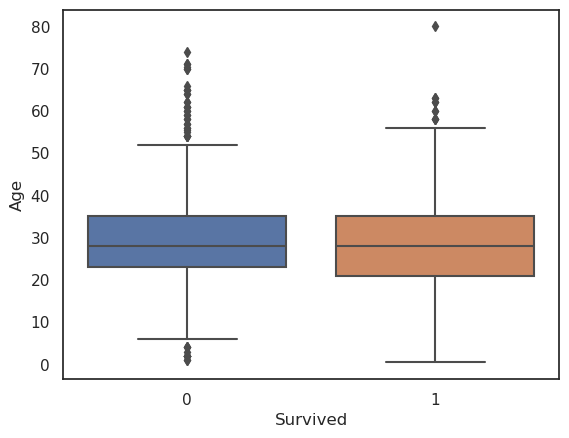

In [56]:
#box plot on Age
sns.boxplot(x="Survived", y="Age", data=train)

<AxesSubplot:xlabel='Survived', ylabel='Sex'>

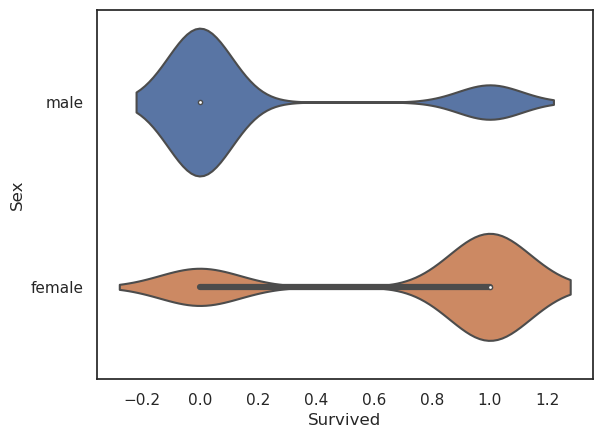

In [57]:
#violin plot on Sex
sns.violinplot(x="Survived", y="Sex", data=train, size=6)

<AxesSubplot:xlabel='Survived', ylabel='Embarked'>

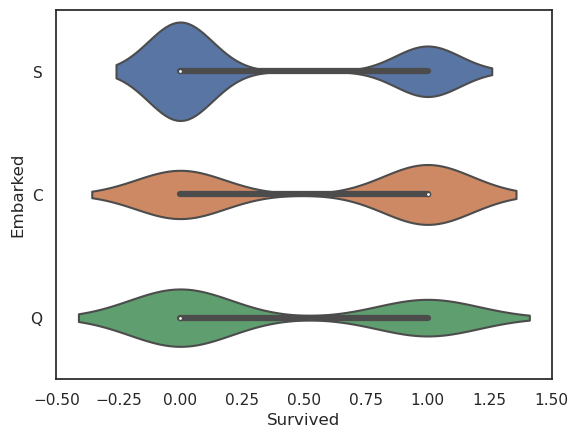

In [58]:
#violin plot on Embarked
sns.violinplot(x="Survived", y="Embarked", data=train)

<AxesSubplot:xlabel='Survived', ylabel='Pclass'>

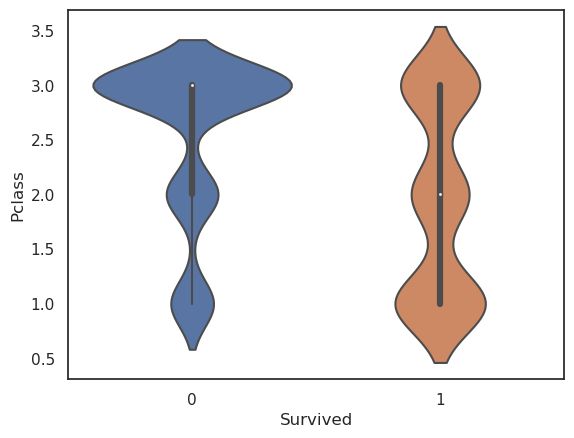

In [59]:
#violin plot on PClasss
sns.violinplot(x="Survived", y="Pclass", data=train)

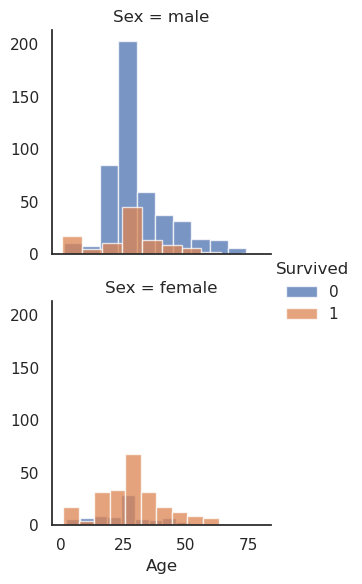

In [60]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(train, row = 'Sex', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

Text(0.5, 1.05, 'Pearson Correlation of Features')

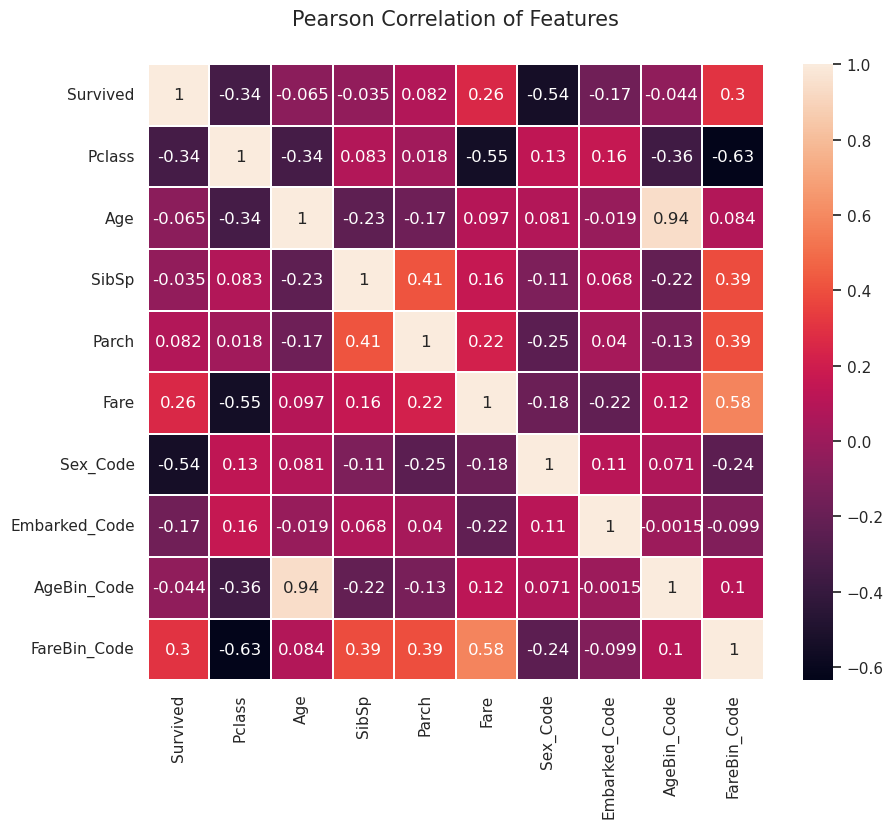

In [61]:
#correlation heatmap of dataset

ax = plt.subplots(figsize =(10, 8))
   
sns.heatmap(
       train.corr(), 
        square=True,      
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }    
    )
    
plt.title('Pearson Correlation of Features', y=1.05, size=15)


From the heat map, we can see that 'Pclass', 'Sex_Code', and 'FareBin_Code' are more correlated with the outcome 'Survived' than other variables. 

**Data Modeling**

We applied a Random Forest algorithm to the dataset with cross validation techniques.

In [62]:
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

#split dataset for cross-validation 
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

#score model with cross validation
cv_results = model_selection.cross_validate(rf, train[train_x_bin], train[Target], cv  = cv_split)

print('Test Score Mean: {:.2f}%'.format(cv_results['test_score'].mean()*100))


Test Score Mean: 81.23%


In [63]:
# Use Random Forest model above to predict passenger survival
rf.fit(train[train_x_bin], train[Target])
predictions = rf.predict(test[train_x_bin])
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.head()


# output.to_csv('submission.csv', index=False)  # save the output as csv if needed

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
